# Parallel Tempering


In this jupyter notebook you can fins the implementation of the parallel tempering algorithm to find the ground state of an 2D Edwards-Anderson spin glass model, which has the following Hamiltonian:

$$H = -\sum_{<ij>}J_{ij}s_is_j,$$

where the couplings $J_{ij}$ are random variables drawn from a Gaussian distribution and we consider only nearest neighbour interactions.
The algorithm can also be implemented for other spin glass problems with different connectivity and dimensionality.

Parallel tempering consists of an implementation of the metropolis algorithm to different copies of a given system, at given temperatures.

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import timeit
import math

After importing the necessary packages we need to define the configuration of the problem. Let's start by defining the lattice. This will be useful to plot the spins.

In [13]:
def Lattice(N):
    '''Square 2D lattice within sqrtN'''
    Position = np.zeros((N,2))
    SqrtN = np.sqrt(N) 
    for i in range(N):
        Position[i][0] = (i%SqrtN)
        Position[i][1] = (i//SqrtN)  
    SpinX = Position[:,0]
    SpinY = Position[:,1]
    return SpinX, SpinY

side = 10
N = side*side #TOTAL NUMBER OF SPINS
SpinX,SpinY = Lattice(N)

Now, let us define the random couplings between nearest neighbours. In this case, we will set them in a NxN matrix, but there are more efficient ways to do it. For example, we could save two couplings for each spin, the one to the left and the one with the spin down from it. Here instead we have a symmetric matrix with a lot of entries being zero, but it helps making the program more intuitive.

In [14]:
def NN_Random_couplings(N, side, SpinX, SpinY):
    '''Computes the symmetric matrix with all random couplings for nearest neighbours PERIODIC BOUNDARY CONDITIONS'''
    Matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            dist_vector = np.array([SpinX[i]-SpinX[j],SpinY[i]-SpinY[j]])
            dist_vector_PBC = (dist_vector + side/2)%side-side/2
            if np.linalg.norm(dist_vector_PBC) == 1:
                Matrix[i][j] = np.random.normal(0,1) #from N(0,1)
                Matrix[j][i] = Matrix[i][j]
    return Matrix  

Matrix = NN_Random_couplings(N,side,SpinX,SpinY)
print(Matrix)
#np.save('Matrix.npy', Matrix)

[[ 0.          0.19159043  0.         ...  0.          0.
   0.        ]
 [ 0.19159043  0.          0.79356073 ...  0.          0.
   0.        ]
 [ 0.          0.79356073  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -1.17958034
   0.        ]
 [ 0.          0.          0.         ... -1.17958034  0.
   0.06702237]
 [ 0.          0.          0.         ...  0.          0.06702237
   0.        ]]


We could also import the couplings from a file to be sure we are working on the same problem all the time:

In [15]:
Matrix = np.load('Matrix10.npy')
print(Matrix)

[[ 0.          0.3764402   0.         ...  0.          0.
   0.        ]
 [ 0.3764402   0.         -1.89813204 ...  0.          0.
   0.        ]
 [ 0.         -1.89813204  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -1.79272444
   0.        ]
 [ 0.          0.          0.         ... -1.79272444  0.
  -0.70226097]
 [ 0.          0.          0.         ...  0.         -0.70226097
   0.        ]]


Now let us define the parameters that we are going to need for the parallel tempering process. The idea behind this algorithm is to consider more than one copy of the system, each one evolving at a different temperature. After some equilibration steps, we will swap two random copies, in such a way that temperature jumps are allowed and we do not get stuck in a local minima. 
- Instead of the Temperature, here we will work with the Beta, which is just 1/T. We will define a set of equally spaced temperatures.
- Here we do not need to define a cooling schedule. Just the number of equilibration steps and the number of steps that the algorithm will take.

In [16]:
Betas = np.arange(1/1.6,1/0.1,0.2)
Replicas = len(Betas)
Ne = 20
Ns = 100

Now let's define the core function of the problem, which will perform a Metropolis sweep over the lattice (this means flipping N spins). The sweep is performed in sequential order, but we could consider N random spins and it should also work. 

First, we will need to define a function that computes the new energy by JUST considering the difference that we obtain from flipping one spin. Since we consider nearest neighbours, computing the whole energy again would be not efficient. Instead, we only have to change the sign of the four interactions that correspond to this one spin. This function can induce some error when we are doing a high number of iterations, and that is why we will do the whole calculation of the energy once in a while.

In [17]:
def Swap(State, Energy, Matrix, i):
    '''Computes the new energy obtained by flipping spin i'''
    NewEnergy = copy.deepcopy(Energy)
    State = np.array(State, float)
    for j in range(N):
        NewEnergy += float(4)*Matrix[i][j]*State[i]*State[j]
    return NewEnergy

The metropolis algorithm is based in the following idea. At a given temperature T, we will ALWAYS accept the moves that lower the energy. The ones that increase it will be accepted depending on a probability that is based on the Boltzmann distribution. Here we have to use random numbers to decide whether we are accepting the perturbation or not.

In [18]:
def Metropolis_sweep(State, Energy, BestEnergy, BestState, Matrix, Beta, N):
    '''Performs a N steps in the Metropolis algorithm and decides whether 
    to accept the moves or not in a given T'''    
    for i in range(N):
        spin = i
        NewEnergy = Swap(State, Energy, Matrix, spin)
        Dif = NewEnergy - Energy
        if Dif < 0: 
            State[spin] = -State[spin]
            Energy = NewEnergy
            if Energy < BestEnergy:
                BestState = copy.deepcopy(State)
                BestEnergy = Energy 
        else:
            Prob = np.exp(-Dif*Beta)
            dummy = random.random()
            if dummy < Prob:
                State[spin] = -State[spin]
                Energy = NewEnergy  
    return State, Energy, BestEnergy, BestState

We will also need a function that, given a vector of configuration of spins, finds the energy of each configuration (with the Hamiltonian that was previously given for EA spin glass).  Here we could add a factor 1/2N.

In [19]:
def Hamiltonian_all(States, Matrix, N):
    '''Computes the cost energy of a a given SET of states'''
    Energies = []
    for confg in States:
        Energy = 0
        confg = np.array(confg, float)
        for i in range(N):
            for j in range(N):
                Energy += -Matrix[i][j]*confg[i]*confg[j]
        Energies = np.append(Energies, Energy)
    return Energies

And we will keep the function that finds the energy of one state because it can be useful later.

In [20]:
def Hamiltonian_one(Spins, Matrix, N):
    '''Computes the cost energy of a given state'''
    Energy = 0
    Spins = np.array(Spins, float)
    for i in range(N):
        for j in range(N):
            Energy += -Matrix[i][j]*Spins[i]*Spins[j]
    return Energy

Now let us define the starting random configuration, which in this case is a configuration for each of the replicas. 

In [21]:
States = []
for replica in range(Replicas):
    if len(States) == 0:
        States = np.sign(np.random.rand(N)*2-1)
    else:
        States = np.vstack((States, np.sign(np.random.rand(N)*2-1)))

We can plot the initial state of one of the replicas to see how it looks like.

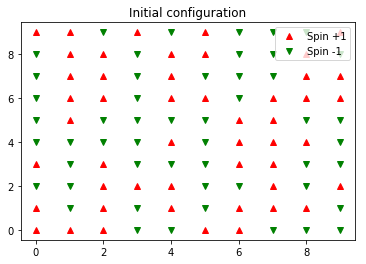

In [22]:
def PlotState(title, State, SpinX, SpinY):
    '''Plots the spin state'''
    plt.figure()
    plt.title(title)
    plt.plot(SpinX[State>0],SpinY[State>0],color='red',marker='^',linestyle='None',label='Spin +1')
    plt.plot(SpinX[State<0],SpinY[State<0],color='green',marker='v',linestyle='None',label='Spin -1')
    plt.legend()

PlotState('Initial configuration', States[0], SpinX, SpinY)  

Now we will start with the process of minimizing the energy. Note that we will save the best energy (and the best state corresponding to it) througout the process and that will be our result. This process would be much faster if we were be parellelizing it. We won't do this in this code, but it would be an interesting implementation.

The procedure will be to equilibrate each replica at one temperature during a number of equilibration steps and then perform a random swap of two consecutive replicas. This step will be repeated through the process.

In [24]:
Steps = 0
Energies = Hamiltonian_all(States,Matrix,N)
BestEnergy = min(Energies)
BestState = States[Energies == BestEnergy]
BestState = BestState[0]
EnergySteps = []

print('\nSTART PARALLEL TEMPERING')
start_program = timeit.default_timer()
#Temperature steps
while Steps <= Ns:
      
    #METROPOLIS TO EACH REPLICA
    for replica in range(Replicas):
        Energy = Energies[replica]
        for i in range(Ne):
            States[replica], Energy, BestEnergy, BestState = Metropolis_sweep(States[replica],Energy,BestEnergy,BestState,Matrix,Betas[replica],N)
        Energies[replica] = Hamiltonian_one(States[replica],Matrix,N)
        BestEnergy = Hamiltonian_one(BestState,Matrix,N)
    EnergySteps = np.append(EnergySteps, min(Energies))
        
    #INTERCHANGE REPLICAS
    Replica1 = np.random.randint(Replicas)
    Replica2 = (Replica1+1)%Replicas
    States[Replica1], States[Replica2] = copy.deepcopy(States[Replica2]), copy.deepcopy(States[Replica1])
    Energies[Replica1], Energies[Replica2] = Energies[Replica2], Energies[Replica1]

    print('End of step ', Steps, '\tmin Min Energy', min(Energies))
    Steps += 1
    
end_program = timeit.default_timer()
print('MINIMUM REACHED IN THE PROCESS: ', BestEnergy)
print('TIME: ', end_program-start_program) 


START PARALLEL TEMPERING
End of step  0 	min Min Energy -251.2800637924474
End of step  1 	min Min Energy -251.2800637924474
End of step  2 	min Min Energy -257.89481515349866
End of step  3 	min Min Energy -257.89481515349866
End of step  4 	min Min Energy -256.6457393276366
End of step  5 	min Min Energy -257.89481515349866
End of step  6 	min Min Energy -258.734466965068
End of step  7 	min Min Energy -257.3572860138904
End of step  8 	min Min Energy -257.72968452211063
End of step  9 	min Min Energy -259.07364973095906
End of step  10 	min Min Energy -259.07364973095906
End of step  11 	min Min Energy -259.07364973095906
End of step  12 	min Min Energy -259.07364973095906
End of step  13 	min Min Energy -256.2709443859908
End of step  14 	min Min Energy -257.47164138999926
End of step  15 	min Min Energy -258.81560659884775
End of step  16 	min Min Energy -258.734466965068
End of step  17 	min Min Energy -258.81560659884775
End of step  18 	min Min Energy -257.72968452211063
End o

Now we can have a look at the state that was found with minimum energy.


THE MINIMUM ENERGY FOUND IS:  -261.8411632886091


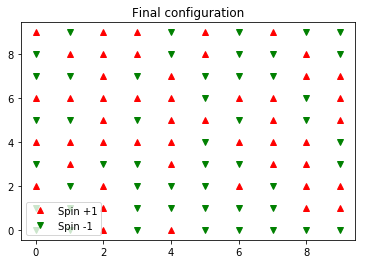

In [26]:
PlotState('Final configuration', BestState, SpinX, SpinY)
GroundState = BestEnergy
print('\nTHE MINIMUM ENERGY FOUND IS: ', GroundState)

And we can also look at the histogram of final states, to see how are they sampled. 

Text(0.5,0,'Energy')

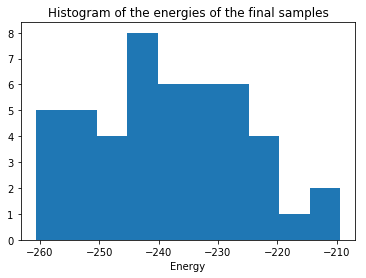

In [27]:
plt.figure()
plt.hist(Energies)
plt.title('Histogram of the energies of the final samples')
plt.xlabel('Energy')

The parameters for this algorithm still need to be tunned in order to get the most out of it. Moreover, if we would parallelize it we could work with a lot more temperatures evolving separately and therefore get a better result.
For now it is working, but we should make sure we always get better results than SA, which according to the literature should happen.